In [8]:
# %pip install -U gymnasium
# %pip install -U gymnasium[classic-control]

In [55]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display
import ipywidgets as widgets
from IPython.display import clear_output
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

## REINFORCE

REINFORCE → REward Increment = Nonnegative Factor x Offset Reinforcement x Characteristic Eligibility

In [31]:
LR = 3e-4
GAMMA = 0.9
MAX_STEPS = 1000
N_HIDDEN = 10
EPS = torch.finfo(torch.float32).eps

In [32]:
class ReinforcePolicy(nn.Module):
    def __init__(self, n_in, n_out, n_hidden=N_HIDDEN):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.f(x)

In [35]:
r_policy = ReinforcePolicy(n_in=4, n_out=2).to(device)
r_scores = []

### train

    0	 loss: 2.1024246215820312	 episode length: 145


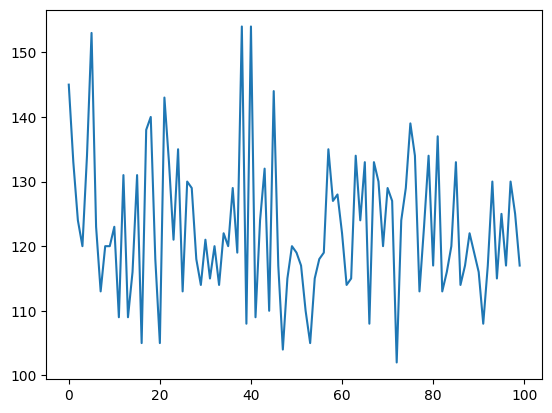

In [49]:
def discount_rewards(rewards, gamma):
    '''
    Compute the discounted rewards backwards through time, e.g.
      r0 + gamma * (r1 + gamma * (r2 + gamma * (...)))
      [----------------------------------------------]
         ^         [---------------------------------]
         |           ^           [-------------------]
      discount[0]    |             ^           [-----]
                  discount[1]      |             ^
                                discount[2]      |
                                              discount[n]                                              
    '''
    reward = 0
    discounted_rewards = []
    for r in rewards[::-1]:
        reward = r + gamma * reward
        discounted_rewards.append(reward)
    return torch.tensor(discounted_rewards[::-1]).to(device)

def train(model, epochs=10, lr=LR, gamma=GAMMA, max_steps=MAX_STEPS, log_every=100, scores=r_scores):
    model = model.to(device)
    model.train()
    opt = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        rewards, log_probs = [], []
        state, _ = env.reset()
        # forward
        for t in range(MAX_STEPS):
            # this feel bad performance wise, 1 cycle GPU, 1 cycle CPU
            # it's too much context switching
            # how can I benchmark this in a notebook?
            actions = model(torch.tensor(state).float().to(device))
            action = torch.multinomial(actions, 1)
            state, reward, done, _, _ = env.step(action.item())
            rewards.append(reward)
            log_probs.append(torch.log(actions[action]))
            if done:
                break
        # backward
        losses = []
        discounted_rewards = discount_rewards(rewards, gamma)
        normalized_discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + EPS)
        for log_prob, reward in zip(log_probs, normalized_discounted_rewards):
            losses.append(-log_prob * reward)
        loss = torch.stack(losses).sum()
        opt.zero_grad()
        loss.backward()
        opt.step()
        if epoch % log_every == 0:
            print(f'{epoch:5}\t loss: {loss.item()}\t episode length: {t}')
        scores.append(t)
    model.eval()

train(r_policy, epochs=100)
plt.plot(r_scores)

In [42]:
# save
# ----
# torch.save(policy.state_dict(), 'weights/cartpole-reinforce-20k-plateau.pt')

# load
# ----
# m = ReinforcePolicy(n_in=4, n_out=2).to(device)
# m.load_state_dict(torch.load('weights/cartpole-reinforce.pt'))

### play

Episode finished after 128 timesteps


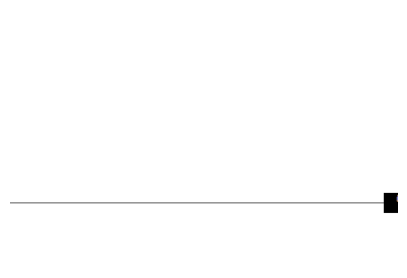

In [41]:
@torch.no_grad()
def show_play(env, policy, max_steps=MAX_STEPS):
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.axis('off')
    state, _ = env.reset()
    img = ax.imshow(env.render())
    for t in range(max_steps):
        actions = policy(torch.tensor(state).float().to(device))
        action = actions.argmax()
        state, _, done, _, _ = env.step(action.item())
        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
        if done:
            print("Episode finished after {} timesteps".format(t + 1))
            break

show_play(env, policy)

### profiling

In [18]:
# split the code in a bunch of functions to make the cProfile easier to read

def gpu_world(model, arg):
    return model(arg)

def cpu_world_simulate_env(env, action):
    return env.step(action.item())

def cpu_world_get_action(actions, log_probs):
    # Categorical seems dog slow
    # --------------------------
    # m = torch.distributions.Categorical(actions)
    # action = m.sample()
    # log_probs.append(m.log_prob(action))

    # multinormal is faster
    # ---------------------
    action = torch.multinomial(actions, 1)
    log_probs.append(torch.log(actions[action]))

    # but they should be equivalent
    # -----------------------------
    # assert m.log_prob(action) - torch.log(actions[action]) < 0.001

    return action

def cpu_world_sample(rewards, log_probs, env, actions):
    action = cpu_world_get_action(actions, log_probs)

    state, reward, done, _, _ = cpu_world_simulate_env(env, action)
    rewards.append(reward)
    return state, done

def cpu_world_backward_pass(rewards, log_probs, gamma):
    losses = []
    discounted_rewards = discount_rewards(rewards, gamma)
    normalized_discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + EPS)
    for log_prob, reward in zip(log_probs, normalized_discounted_rewards):
        losses.append(-log_prob * reward)
    return losses

def gpu_world_backward_pass(losses, opt):
    loss = torch.stack(losses).to(device).sum()
    opt.zero_grad()
    loss.backward()
    opt.step()
    return loss

def train_for_profiling(model, epochs=100, lr=LR, gamma=GAMMA, max_steps=MAX_STEPS):
    model = model.to(device)
    model.train()
    opt = optim.Adam(policy.parameters(), lr=lr)
    for epoch in range(epochs):
        rewards, log_probs = [], []
        state, _ = env.reset()
        # forward pass
        for _ in range(MAX_STEPS):
            actions = gpu_world(policy, torch.tensor(state).float().to(device))
            state, done = cpu_world_sample(rewards, log_probs, env, actions)
            if done: break
        # backward pass
        losses = cpu_world_backward_pass(rewards, log_probs, gamma)
        loss = gpu_world_backward_pass(losses, opt)
        if epoch % 10 == 0:
            print(f'{epoch:5} {loss.item()}')

In [19]:
import cProfile
import pstats
import io

def profile_train(model):
    pr = cProfile.Profile()
    pr.enable()
    train_for_profiling(model)
    pr.disable()
    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
    ps.print_stats()
    return s.getvalue()

profile_output = profile_train(policy)
print(profile_output)

    0 -1.3113069534301758
   10 1.2661182880401611
   20 -0.029778003692626953
   30 0.24195194244384766
   40 -0.751434326171875
   50 0.5891878604888916
   60 0.6964113712310791
   70 1.4417979717254639
   80 0.14848625659942627
   90 0.15641844272613525
         227136 function calls (209796 primitive calls) in 5.057 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.060    0.060    5.057    5.057 C:\Users\p\AppData\Local\Temp\ipykernel_33816\4058240708.py:49(train_for_profiling)
      100    0.001    0.000    1.921    0.019 C:\Users\p\AppData\Local\Temp\ipykernel_33816\4058240708.py:42(gpu_world_backward_pass)
      100    0.001    0.000    1.843    0.018 c:\Users\p\Desktop\_ML\huggingface-nlp-course\venv\Lib\site-packages\torch\_tensor.py:428(backward)
      100    0.001    0.000    1.841    0.018 c:\Users\p\Desktop\_ML\huggingface-nlp-course\venv\Lib\site-packages\torch\autograd\__init__.py:106(backward)

## REINFORCE with Baseline


We introduce a `Value` net in the hope to reduce the variance (converge faster). So it's not a pure policy technique anymore.

Advantage = discounted_reward - predicted_value

In [73]:
LR = 3e-4
GAMMA = 0.9
MAX_STEPS = 1000
N_HIDDEN = 32
EPS = torch.finfo(torch.float32).eps

In [47]:
class ReinforceBaselinePolicy(nn.Module):
    def __init__(self, n_in, n_out, n_hidden=N_HIDDEN):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.f(x)
    
class ReinforceBaselineValue(nn.Module):
    def __init__(self, n_in, n_hidden=N_HIDDEN):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        return self.f(x)


In [48]:
rb_policy = ReinforceBaselinePolicy(n_in=4, n_out=2).to(device)
rb_value = ReinforceBaselineValue(n_in=4).to(device)
rb_scores = []

### train

    0	 loss: 14.693782806396484	 episode length: 208
  100	 loss: 9.35795783996582	 episode length: 172
  200	 loss: -16.888282775878906	 episode length: 456
  300	 loss: 8.462139129638672	 episode length: 232
  400	 loss: 9.479345321655273	 episode length: 255
  500	 loss: 5.7635650634765625	 episode length: 364
  600	 loss: 28.001615524291992	 episode length: 263
  700	 loss: -15.114140510559082	 episode length: 357
  800	 loss: 3.398425579071045	 episode length: 362
  900	 loss: -8.149380683898926	 episode length: 366


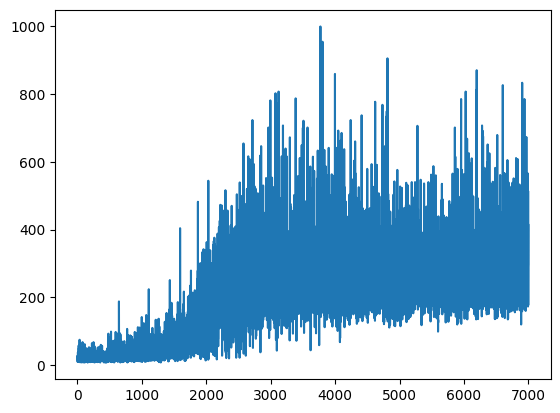

In [72]:
def train(policy, value, epochs=10, lr=LR, gamma=GAMMA, max_steps=MAX_STEPS, log_every=100):#, scores=rb_scores):
    policy = policy.to(device)
    value = value.to(device)
    policy.train()
    value.train()
    opt_p = optim.Adam(policy.parameters(), lr=lr)
    opt_v = optim.Adam(value.parameters(), lr=lr)
    for epoch in range(epochs):
        rewards, log_probs, values = [], [], []
        state, _ = env.reset()
        # forward
        for t in range(MAX_STEPS):
            state = torch.tensor(state).float().to(device)
            values.append(value(state))
            actions = policy(state)
            action = torch.multinomial(actions, 1)
            state, reward, done, _, _ = env.step(action.item())
            rewards.append(reward)
            log_probs.append(torch.log(actions[action]))
            if done:
                break
        
        # backward
        values = torch.cat(values)
        discounted_rewards = discount_rewards(rewards, gamma)
        # backward value
        loss = F.mse_loss(values, discounted_rewards)
        opt_v.zero_grad()
        loss.backward(retain_graph=True)
        opt_v.step()
        # backward policy
        losses = []
        advantages = discounted_rewards - values
        for log_prob, advantage in zip(log_probs, advantages):
            losses.append(-log_prob * advantage)
        loss = torch.stack(losses).sum()
        opt_p.zero_grad()
        loss.backward()
        opt_p.step()

        if epoch % log_every == 0:
            print(f'{epoch:5}\t loss: {loss.item()}\t episode length: {t}')
        scores.append(t)
    policy.eval()
    value.eval()

train(rb_policy, rb_value, epochs=1000)
plt.plot(scores)

In [74]:
# save
# ----
torch.save(rb_policy.state_dict(), 'weights/rb_policy-cartpole.pt')
torch.save(rb_value.state_dict(), 'weights/rb_value-cartpole.pt')

# load
# ----
# mp = ReinforceBaselinePolicy(n_in=4, n_out=2).to(device)
# mp.load_state_dict(torch.load('weights/rb_policy-cartpole.pt'))
# mv = ReinforceBaselineValue(n_in=4).to(device)
# mv.load_state_dict(torch.load('weights/rb_value-cartpole.pt'))

### play

Episode finished after 478 timesteps


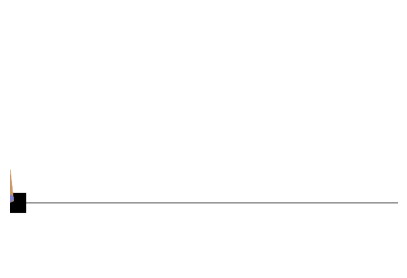

In [71]:
show_play(env, rb_policy)

## Actor Critic

Similar to REINFORCE with Baseline but include TD (Temporal Difference) method so we are more sample efficient (aka. we can train on individual steps instead of entire episodes).

## A2C

In [20]:
class Actor(nn.Module):
    def __init__(self, n_in, n_out, n_hidden=10):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.f(x)

class Critic(nn.Module):
    def __init__(self, n_in, n_hidden=10):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        return self.f(x)

actor = Actor(n_in=10, n_out=2)
critic = Critic(n_in=10)

In [21]:
def train(epochs=100, lr=LR):
    actor_opt = optim.Adam(actor.parameters(), lr=lr)
    critic_opt = optim.Adam(critic.parameters(), lr=lr)

    for epoch in range(epochs):
        state = env.reset()
        done = False

        while not done:
            action_probs = actor(torch.from_numpy(state).float())
            action = torch.multinomial(action_probs, 1).item()

            next_state, reward, done, _ = env.step(action)

            V_current = critic(torch.from_numpy(state).float())
            V_next = critic(torch.from_numpy(next_state).float())

            # Compute advantage and TD-target
            advantage = reward + (1 - int(done)) * V_next - V_current
            td_target = reward + (1 - int(done)) * V_next

            # Update the critic
            critic_loss = advantage.pow(2)
            critic_opt.zero_grad()
            critic_loss.backward()
            critic_opt.step()

            # Update the actor
            actor_loss = -torch.log(action_probs[action]) * advantage.detach()
            actor_opt.zero_grad()
            actor_loss.backward()
            actor_opt.step()

            state = next_state

# PPO

$L^{CPI}(\theta) = \mathbb{E}_t [ \frac{\pi_\theta(a_t | s_t)}{\pi_{{\theta}_{old}(a_t | s_t)}} A_t] = \mathbb{E}_t [r_t(\theta)A_t]$

$L^{CLIP}(\theta) = \mathbb{E}_t [min(r_t(\theta)A_t, clip(r_t(\theta), 1 - \epsilon, 1 + \epsilon) A_t)]$


- $\mathbb{E}$ : expected value
- $A$: advantage